 This script loads four CSVs (assets, employees, incidents, threats) from disk, previews them, and then merges them into one analysis-ready table using the foreign keys in incidents (threat_id, asset_id, employee_id). After merging, it standardizes important fields: converts detection_time to a timestamp, derives a proper severity column from threat_severity (defaulting to “unknown”), and safely constructs a human-readable description string by first casting all parts to text (to avoid type errors) and concatenating threat, type, asset, user, and severity details. It also normalizes some column names that come from prefixed joins (e.g., asset_owner_department, asset_vulnerability_score, emp_department, emp_security_training) so they exist consistently, then selects a tidy set of columns (incident, threat, asset, employee, metrics) and sorts by time. Finally, it writes the result to merged_cyber_incidents.csv and prints quick counts for threat_type, severity, and status to sanity-check the merge.

In [3]:
# == Merge Cybersecurity CSVs into One Analysis-Ready Table ==
# Works in Colab/Jupyter/VS Code. Assumes files are in /content/*.csv.
# Change the paths dict if your files live elsewhere.

import os
import pandas as pd

# 1) File paths
paths = {
    "assets": "/content/assets.csv",
    "employees": "/content/employees.csv",
    "incidents": "/content/incidents.csv",
    "threats": "/content/threats.csv",
}

# 2) Robust CSV loader
def read_csv_safely(p):
    if not os.path.exists(p):
        print(f"[WARN] Not found: {p}")
        return None
    try:
        return pd.read_csv(p)
    except UnicodeDecodeError:
        return pd.read_csv(p, encoding="latin-1")

loaded = {name: read_csv_safely(p) for name, p in paths.items()}

# 3) Quick previews (works in notebooks & scripts)
try:
    from IPython.display import display
    def show(df, title):
        print(f"\n=== {title} (shape={df.shape}) ===")
        display(df.head(20))
except Exception:
    def show(df, title):
        print(f"\n=== {title} (shape={df.shape}) ===")
        print(df.head(20).to_string(index=False))

for name, df in loaded.items():
    if df is None:
        raise FileNotFoundError(f"Missing required CSV: {name} -> {paths[name]}")
    show(df, f"{name}.csv preview")

# 4) Merge using foreign keys
assets    = loaded["assets"]
employees = loaded["employees"]
incidents = loaded["incidents"]
threats   = loaded["threats"]

m = incidents.merge(
        threats.add_prefix("threat_"),
        left_on="threat_id", right_on="threat_threat_id", how="left"
    ).merge(
        assets.add_prefix("asset_"),
        left_on="asset_id", right_on="asset_asset_id", how="left"
    ).merge(
        employees.add_prefix("emp_"),
        left_on="employee_id", right_on="emp_employee_id", how="left"
    )

# 5) Standardize key columns
m["timestamp"] = pd.to_datetime(m["detection_time"], errors="coerce")

# severity as a proper Series (not a scalar), fallback to "unknown"
m["severity"] = (
    m["threat_severity"].astype("string").fillna("unknown")
    if "threat_severity" in m.columns else "unknown"
)

# Force all description parts to string to prevent TypeError during concat
def ensure_str(colname):
    if colname in m.columns:
        m[colname] = m[colname].astype("string").fillna("")
    else:
        m[colname] = ""

for col in ["threat_name","threat_type","asset_name","asset_type","emp_name","threat_severity"]:
    ensure_str(col)

# Build description safely
m["description"] = (
    "Threat: " + m["threat_name"] + "; "
    + "Type: " + m["threat_type"] + "; "
    + "Asset: " + m["asset_name"] + " (" + m["asset_type"] + "); "
    + "User: " + m["emp_name"] + "; "
    + "Severity: " + m["threat_severity"]
).str.replace(r"\s+;", ";", regex=True).str.strip("; ").str.strip()

# 6) Normalize column names you’ll keep (create consistent names if missing)
# Some prefixed columns after merge have names like asset_owner_department, emp_department, etc.
if "asset_owner_department" not in m.columns and "owner_department" in assets.columns:
    m["asset_owner_department"] = assets["owner_department"]
if "asset_vulnerability_score" not in m.columns and "vulnerability_score" in assets.columns:
    m["asset_vulnerability_score"] = m["vulnerability_score"]

if "emp_department" not in m.columns and "department" in employees.columns:
    m["emp_department"] = m["department"]
if "emp_security_training" not in m.columns and "security_training" in employees.columns:
    m["emp_security_training"] = m["security_training"]

# 7) Final tidy table
final_cols = [
    "incident_id","timestamp","status",
    "threat_id","threat_name","threat_type","severity",
    "asset_id","asset_name","asset_type","asset_owner_department","asset_vulnerability_score",
    "employee_id","emp_name","emp_department","emp_security_training",
    "time_to_resolve_hours","data_breached_gb","financial_impact_k",
    "description"
]

# Keep only columns that exist; warn for any that don't
missing = [c for c in final_cols if c not in m.columns]
if missing:
    print(f"[INFO] These expected columns were not found and will be skipped: {missing}")
available_cols = [c for c in final_cols if c in m.columns]

final = m[available_cols].copy().sort_values("timestamp")

# 8) Save merged CSV
out_path = "/content/merged_cyber_incidents.csv"
final.to_csv(out_path, index=False)

print(f"\n✅ Merged dataset saved to: {out_path}  (rows={len(final)}, cols={final.shape[1]})")
show(final, "Merged dataset (first 20 rows)")

# 9) Quick sanity counts
def safe_counts(series_name):
    if series_name in final.columns:
        print(f"\n - {series_name}:\n", final[series_name].value_counts(dropna=False))
    else:
        print(f"\n - {series_name}: [column not present]")

print("\nCounts:")
safe_counts("threat_type")
safe_counts("severity")
safe_counts("status")


=== assets.csv preview (shape=(50, 5)) ===


,asset_id,name,type,owner_department,vulnerability_score
0,1,Fieldseismologist Database 1,Database,Databaseadministrator,1
1,2,"Engineer,materials Database 2",Workstation,Databaseadministrator,7
2,3,Purchasingmanager Server 3,Server,Miningengineer,5
3,4,Planninganddevelopmentsurveyor Server 4,Database,Miningengineer,2
4,5,Planninganddevelopmentsurveyor Database 5,Database,Purchasingmanager,1
5,6,Fieldseismologist Cloud Storage 6,Cloud Storage,Databaseadministrator,9
6,7,Fieldseismologist Server 7,Workstation,Miningengineer,1
7,8,"Administrator,CivilService Database 8",Cloud Storage,Planninganddevelopmentsurveyor,6
8,9,Databaseadministrator Server 9,Workstation,"Engineer,materials",1
9,10,Electricalengineer Database 10,Server,"Physicist,medical",1



=== employees.csv preview (shape=(15, 4)) ===


,employee_id,name,department,security_training
0,1,John Nelson,Consultingcivilengineer,Pending
1,2,Angela Sanchez,Gamesdeveloper,Completed
2,3,Veronica Fitzgerald,Purchasingmanager,Completed
3,4,Christopher Miller,"Engineer,materials",Completed
4,5,Megan Garcia,"Physicist,medical",Completed
5,6,Jeremy Allen,Databaseadministrator,Pending
6,7,Amy Cox,Electricalengineer,Completed
7,8,Alyssa Carpenter,"Administrator,CivilService",Pending
8,9,Emily Soto,Themeparkmanager,Pending
9,10,Eric Perez,Childpsychotherapist,Completed



=== incidents.csv preview (shape=(5000, 9)) ===


,incident_id,threat_id,asset_id,employee_id,detection_time,status,time_to_resolve_hours,data_breached_gb,financial_impact_k
0,1,5,32,1,2020-12-31 08:42:10.560393,Resolved,138,0.00,142.11
1,2,3,46,1,2023-03-13 05:06:53.560393,Resolved,143,89.71,2378.24
2,3,4,12,12,2020-11-03 23:00:46.560393,Resolved,41,5.49,268.54
3,4,2,14,9,2022-11-10 13:44:09.560393,Resolved,59,0.00,32.18
4,5,2,2,3,2024-02-02 10:17:20.560393,Resolved,29,32.14,1279.37
5,6,5,49,11,2022-12-16 19:12:26.560393,Resolved,49,50.38,994.35
6,7,5,20,9,2022-07-14 21:38:02.560393,Resolved,155,76.70,3775.95
7,8,1,7,8,2022-06-23 06:40:49.560393,Resolved,110,0.00,9.53
8,9,1,10,8,2020-10-27 01:23:13.560393,Resolved,5,0.00,19.60
9,10,1,22,12,2022-05-22 15:21:29.560393,Investigating,17,0.00,40.45



=== threats.csv preview (shape=(5, 4)) ===


,threat_id,name,type,severity
0,1,Phishing,Social Engineering,3
1,2,Malware,Malicious Code,6
2,3,Ransomware,Malicious Code,10
3,4,DoS Attack,Denial of Service,8
4,5,Insider Threat,Insider,9



✅ Merged dataset saved to: /content/merged_cyber_incidents.csv  (rows=5000, cols=20)

=== Merged dataset (first 20 rows) (shape=(5000, 20)) ===


,incident_id,timestamp,status,threat_id,threat_name,threat_type,severity,asset_id,asset_name,asset_type,asset_owner_department,asset_vulnerability_score,employee_id,emp_name,emp_department,emp_security_training,time_to_resolve_hours,data_breached_gb,financial_impact_k,description
3249,3250,2020-08-09 08:54:09.560393,Resolved,2,Malware,Malicious Code,6,22,Electricalengineer Cloud Storage 22,Database,"Engineer,materials",4,8,Alyssa Carpenter,"Administrator,CivilService",Pending,222,10.10,348.96,Threat: Malware; Type: Malicious Code; Asset: ...
2450,2451,2020-08-09 19:51:30.560393,Closed,1,Phishing,Social Engineering,3,5,Planninganddevelopmentsurveyor Database 5,Database,Purchasingmanager,1,6,Jeremy Allen,Databaseadministrator,Pending,39,2.12,49.10,Threat: Phishing; Type: Social Engineering; As...
86,87,2020-08-10 05:29:19.560393,Resolved,2,Malware,Malicious Code,6,15,Childpsychotherapist Server 15,Workstation,Childpsychotherapist,1,10,Eric Perez,Childpsychotherapist,Completed,47,0.00,37.07,Threat: Malware; Type: Malicious Code; Asset: ...
3235,3236,2020-08-10 08:03:26.560393,Resolved,2,Malware,Malicious Code,6,13,Databaseadministrator Cloud Storage 13,Database,Themeparkmanager,3,6,Jeremy Allen,Databaseadministrator,Pending,68,0.00,40.60,Threat: Malware; Type: Malicious Code; Asset: ...
3299,3300,2020-08-10 12:51:08.560393,Investigating,1,Phishing,Social Engineering,3,48,Planninganddevelopmentsurveyor Cloud Storage 48,Server,Gamesdeveloper,1,5,Megan Garcia,"Physicist,medical",Completed,67,4.35,95.58,Threat: Phishing; Type: Social Engineering; As...
2535,2536,2020-08-10 15:46:38.560393,Resolved,4,DoS Attack,Denial of Service,8,29,Fieldseismologist Cloud Storage 29,Database,"Engineer,materials",3,2,Angela Sanchez,Gamesdeveloper,Completed,109,0.00,81.50,Threat: DoS Attack; Type: Denial of Service; A...
2231,2232,2020-08-10 16:26:44.560393,Closed,2,Malware,Malicious Code,6,3,Purchasingmanager Server 3,Server,Miningengineer,5,1,John Nelson,Consultingcivilengineer,Pending,21,0.00,20.88,Threat: Malware; Type: Malicious Code; Asset: ...
621,622,2020-08-11 05:15:01.560393,Resolved,3,Ransomware,Malicious Code,10,30,Electricalengineer Cloud Storage 30,Workstation,Purchasingmanager,2,11,Shaun Ortega,Clinicalresearchassociate,Completed,33,15.47,228.17,Threat: Ransomware; Type: Malicious Code; Asse...
2416,2417,2020-08-11 07:44:14.560393,Resolved,5,Insider Threat,Insider,9,22,Electricalengineer Cloud Storage 22,Database,"Engineer,materials",4,11,Shaun Ortega,Clinicalresearchassociate,Completed,155,0.00,28.36,Threat: Insider Threat; Type: Insider; Asset: ...
3688,3689,2020-08-11 13:06:35.560393,Resolved,1,Phishing,Social Engineering,3,49,Electricalengineer Cloud Storage 49,Cloud Storage,Electricalengineer,3,15,Amy Lawrence,Miningengineer,Completed,35,10.48,151.71,Threat: Phishing; Type: Social Engineering; As...



Counts:

 - threat_type:
 threat_type
Social Engineering    2274
Malicious Code        1965
Insider                499
Denial of Service      262
Name: count, dtype: Int64

 - severity:
 severity
3     2274
6     1467
9      499
10     498
8      262
Name: count, dtype: Int64

 - status:
 status
Resolved         3962
Closed            809
Investigating     229
Name: count, dtype: int64


In [5]:
# =========================
# Cyber Plots (Matplotlib)
# =========================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# --------- CONFIG ---------
MERGED_PATH = "/content/merged_cyber_incidents.csv"  # change if needed
DATE_FROM = None   # e.g., "2025-01-01"
DATE_TO   = None   # e.g., "2025-12-31"

# --------- LOAD ----------
if not os.path.exists(MERGED_PATH):
    raise FileNotFoundError(f"File not found: {MERGED_PATH}")

df = pd.read_csv(MERGED_PATH)
if "timestamp" in df.columns:
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")

    # Optional date filter
if "timestamp" in df.columns and (DATE_FROM or DATE_TO):
    m = pd.Series(True, index=df.index)
    if DATE_FROM:
        m &= df["timestamp"] >= pd.to_datetime(DATE_FROM)
    if DATE_TO:
        m &= df["timestamp"] <= pd.to_datetime(DATE_TO)
    df = df[m]

  # Normalize expected columns
for c in ["threat_type","severity","status","asset_owner_department",
          "time_to_resolve_hours","financial_impact_k","data_breached_gb",
          "asset_name","emp_name","description"]:
    if c not in df.columns:
        df[c] = np.nan


In [16]:

# --------- HELPERS ----------
def _bar(series, title, xlabel, ylabel="Count", rotation=0):
    plt.figure()
    series.plot(kind="bar")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=rotation)
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    plt.show()

def _line(index, values, title, xlabel, ylabel):
    plt.figure()
    plt.plot(index, values)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    plt.show()

def _hist(series, title, xlabel, bins=30):
    plt.figure()
    plt.hist(series.dropna(), bins=bins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

def _box(df, xcol, ycol, title):
    # Simple grouped boxplot via pivot
    sub = df[[xcol, ycol]].dropna()
    if sub.empty:
        print(f"[skip] No data for {title}")
        return
    groups = [g[ycol].values for _, g in sub.groupby(xcol)]
    labels = [str(k) for k, _ in sub.groupby(xcol)]
    plt.figure()
    plt.boxplot(groups, labels=labels, showfliers=False)
    plt.title(title)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    plt.tight_layout()
    plt.show()

def _scatter(x, y, title, xlabel, ylabel):
    plt.figure()
    plt.scatter(x, y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()


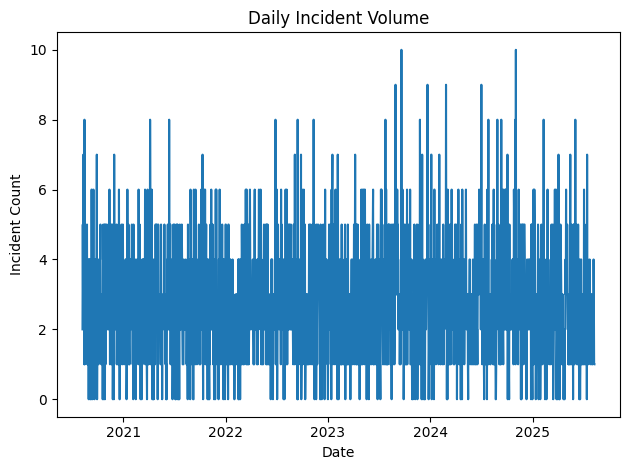

In [17]:
# --------- PLOTS ----------
# 1) Daily incident volume
if "timestamp" in df.columns and pd.api.types.is_datetime64_any_dtype(df["timestamp"]):
    daily = df.set_index("timestamp").resample("D").size()
    if len(daily) > 0:
        _line(daily.index, daily.values, "Daily Incident Volume", "Date", "Incident Count")



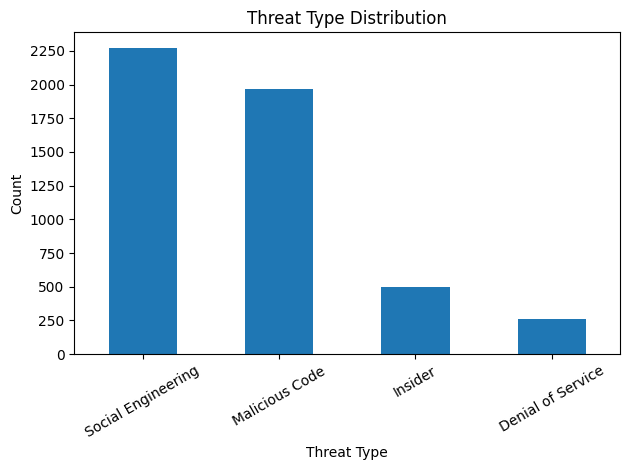

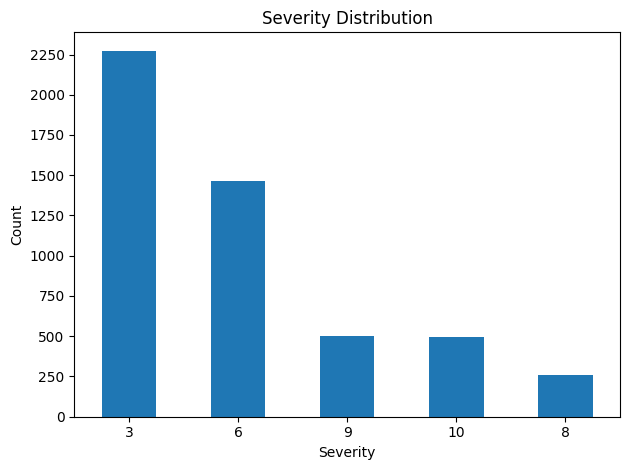

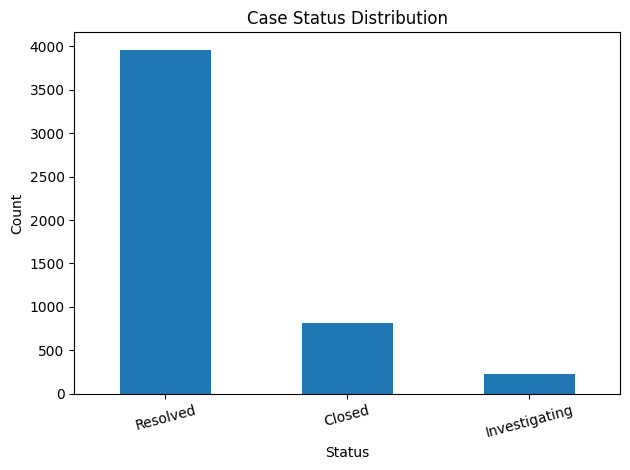

In [18]:
# 2) Distributions
if df["threat_type"].notna().any():
    _bar(df["threat_type"].value_counts(), "Threat Type Distribution", "Threat Type", rotation=30)

if df["severity"].notna().any():
    _bar(df["severity"].value_counts(), "Severity Distribution", "Severity")

if df["status"].notna().any():
    _bar(df["status"].value_counts(), "Case Status Distribution", "Status", rotation=15)

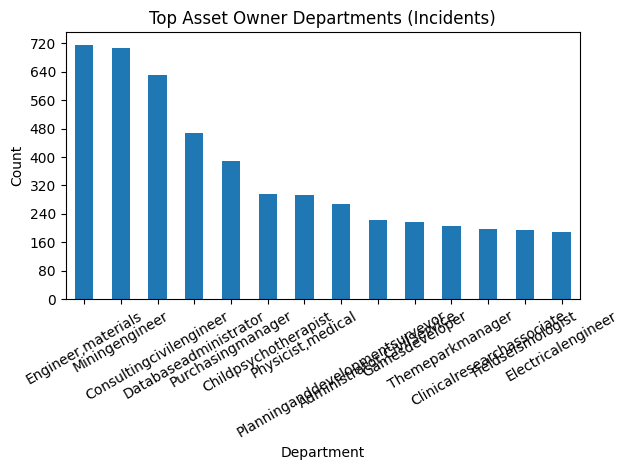

In [20]:
# 3) Top departments (assets owner)
if df["asset_owner_department"].notna().any():
    top_depts = df["asset_owner_department"].value_counts().head(20)
    _bar(top_depts, "Top Asset Owner Departments (Incidents)", "Department", rotation=30)

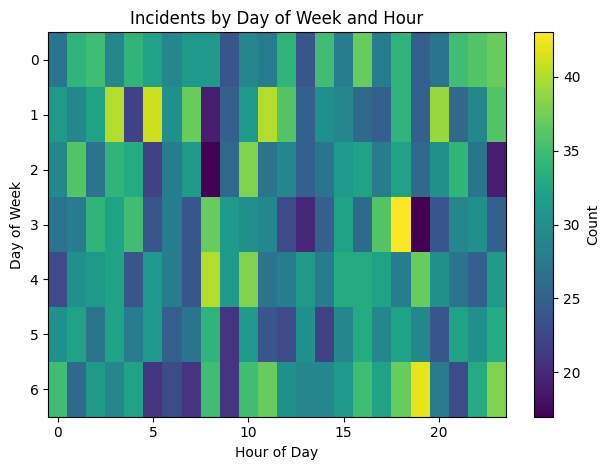

In [21]:
# 4) Heatmap Day x Hour
if "timestamp" in df.columns and pd.api.types.is_datetime64_any_dtype(df["timestamp"]):
    temp = df.copy()
    temp["dow"] = temp["timestamp"].dt.day_name()
    temp["hour"] = temp["timestamp"].dt.hour
    pivot = pd.pivot_table(temp, values="incident_id" if "incident_id" in temp.columns else "timestamp",
                           index="dow", columns="hour", aggfunc="count", fill_value=0)
    order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
    pivot = pivot.reindex(order)
    plt.figure()
    plt.imshow(pivot.values, aspect="auto")
    plt.title("Incidents by Day of Week and Hour")
    plt.xlabel("Hour of Day")
    plt.ylabel("Day of Week")
    plt.colorbar(label="Count")
    plt.tight_layout()
    plt.show()

/tmp/ipython-input-1258154062.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels, showfliers=False)


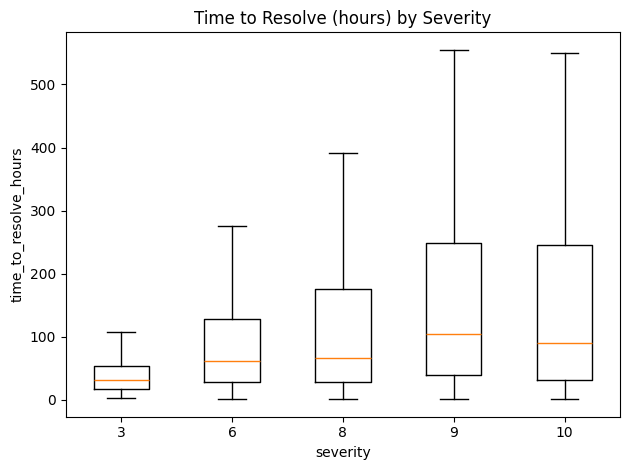

/tmp/ipython-input-1258154062.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels, showfliers=False)


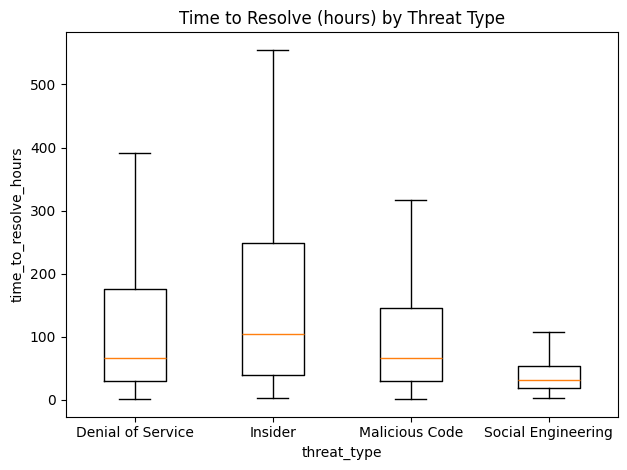

In [23]:
# 5) Boxplots (resolution time by severity / threat_type)
if df["time_to_resolve_hours"].notna().any():
    _box(df, "severity", "time_to_resolve_hours", "Time to Resolve (hours) by Severity")
    if df["threat_type"].notna().any():
        _box(df, "threat_type", "time_to_resolve_hours", "Time to Resolve (hours) by Threat Type")


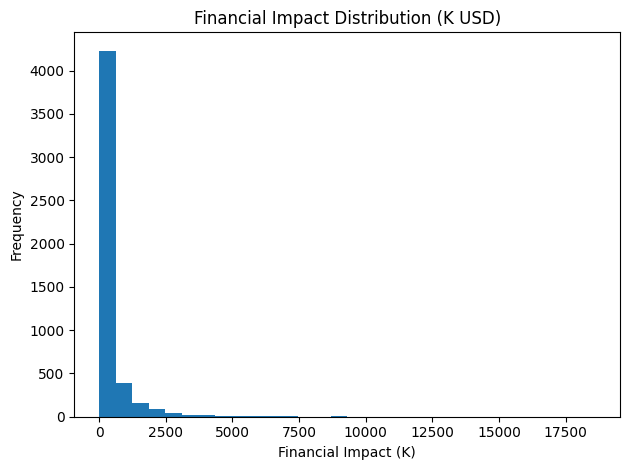

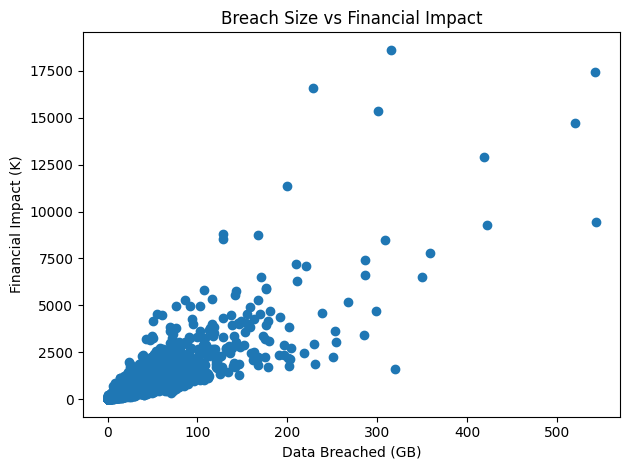

In [24]:
# 6) Cost & impact
if df["financial_impact_k"].notna().any():
    _hist(df["financial_impact_k"], "Financial Impact Distribution (K USD)", "Financial Impact (K)")
if df["data_breached_gb"].notna().any() and df["financial_impact_k"].notna().any():
    _scatter(df["data_breached_gb"], df["financial_impact_k"],
             "Breach Size vs Financial Impact", "Data Breached (GB)", "Financial Impact (K)")


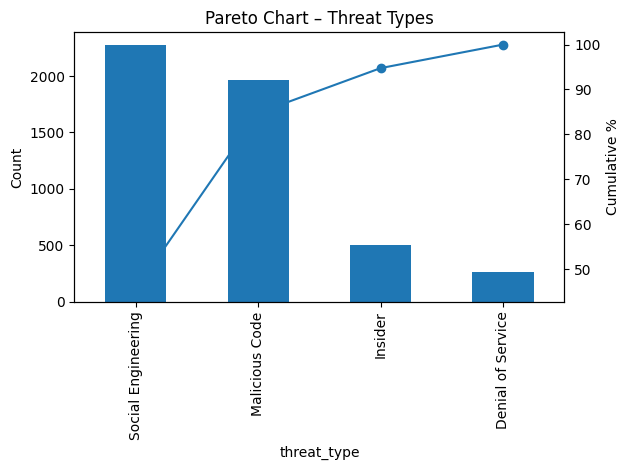

In [25]:
# 7) Pareto (Threat Type) – cumulative %
if df["threat_type"].notna().any():
    counts = df["threat_type"].value_counts()
    cum_pct = counts.cumsum()/counts.sum()*100
    plt.figure()
    ax = counts.plot(kind="bar")
    ax.set_ylabel("Count")
    plt.twinx()
    plt.plot(range(len(cum_pct)), cum_pct.values, marker="o")
    plt.ylabel("Cumulative %")
    plt.title("Pareto Chart – Threat Types")
    plt.tight_layout()
    plt.show()

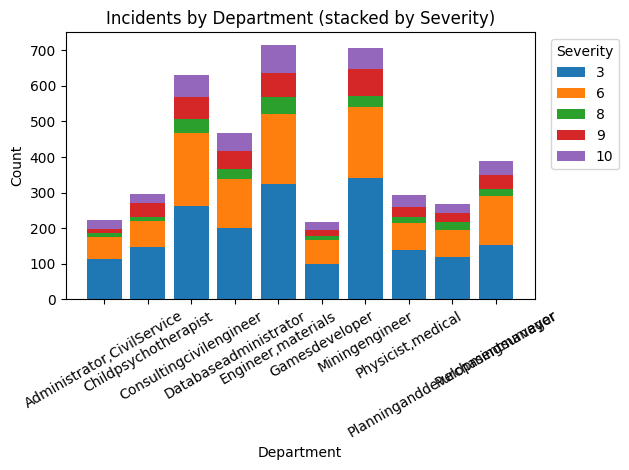


Done. Generated trend, distribution, heatmap, KPI, boxplot, and risk/cost charts.


In [26]:
# 8) Stacked severity by department (Top 10 depts)
if df["asset_owner_department"].notna().any() and df["severity"].notna().any():
    top10 = df["asset_owner_department"].value_counts().head(10).index
    sub = df[df["asset_owner_department"].isin(top10)]
    ctab = pd.crosstab(sub["asset_owner_department"], sub["severity"])
    ctab = ctab[sorted(ctab.columns)]  # sort severity columns alpha
    # Stacked bar
    plt.figure()
    bottom = np.zeros(len(ctab))
    idx = np.arange(len(ctab))
    for col in ctab.columns:
        plt.bar(idx, ctab[col].values, bottom=bottom, label=str(col))
        bottom += ctab[col].values
    plt.title("Incidents by Department (stacked by Severity)")
    plt.xlabel("Department")
    plt.ylabel("Count")
    plt.xticks(idx, ctab.index, rotation=30)
    plt.legend(title="Severity", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

print("\nDone. Generated trend, distribution, heatmap, KPI, boxplot, and risk/cost charts.")

Severity Classifier: {'accuracy': 1.0, 'f1_weighted': 1.0, 'labels': ['10', '3', '6', '8', '9']}


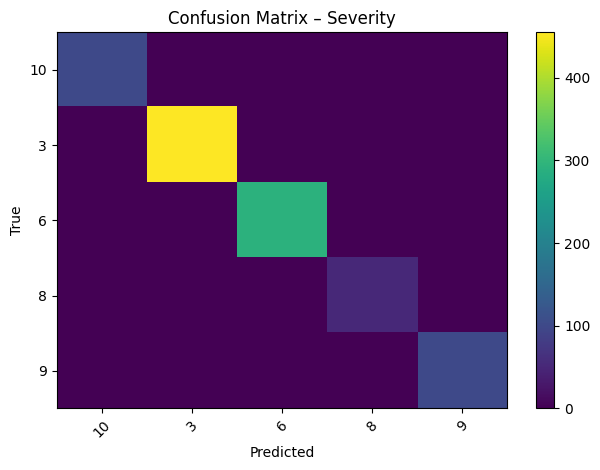

is_high_critical class counts: {0: 5000}
MTTR Regression: {'MAE_hours': 111.112, 'R2': 0.009, 'n_test': 1000}
RAG example hits (top 5):
                    timestamp         threat_type severity         status  \
0 2020-08-09 08:54:09.560393      Malicious Code        6       Resolved   
1 2025-08-08 02:37:14.560393  Social Engineering        3         Closed   
2 2025-08-07 05:54:42.560393  Social Engineering        3       Resolved   
3 2025-08-06 22:54:11.560393  Social Engineering        3  Investigating   
4 2025-08-06 18:24:25.560393  Social Engineering        3       Resolved   

                            asset_name             emp_name  \
0  Electricalengineer Cloud Storage 22     Alyssa Carpenter   
1     Fieldseismologist Workstation 37  Veronica Fitzgerald   
2        Purchasingmanager Database 39     Alyssa Carpenter   
3   Physicist,medical Cloud Storage 27         Shaun Ortega   
4           Gamesdeveloper Database 41         Anita Wright   

                           

In [31]:
# ==== FIXED: Models + RAG (safe masks + safe stratify) ====
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (
    accuracy_score, f1_score, precision_recall_fscore_support,
    mean_absolute_error, r2_score, confusion_matrix
)
from scipy.sparse import hstack

# --- helper: safe stratify ---
def _safe_stratify(y_series):
    """Return y_series for stratify only if >=2 classes and min count >= 2; else None."""
    vc = y_series.value_counts()
    if len(vc) >= 2 and (vc.min() >= 2):
        return y_series
    return None

# ------------------- Model A: Severity Classifier -------------------
y_sev = df["severity"]
mask_A = y_sev.notna().to_numpy()            # <-- FIX: convert mask to numpy
X_A = X[mask_A]
y_A = y_sev[mask_A]

strat_A = _safe_stratify(y_A)
Xa_tr, Xa_te, ya_tr, ya_te = train_test_split(
    X_A, y_A, test_size=0.2, random_state=42, stratify=strat_A
)

clf_sev = LogisticRegression(max_iter=400)
clf_sev.fit(Xa_tr, ya_tr)
ya_pred = clf_sev.predict(Xa_te)
sev_metrics = {
    "accuracy": round(accuracy_score(ya_te, ya_pred), 4),
    "f1_weighted": round(f1_score(ya_te, ya_pred, average="weighted"), 4),
    "labels": sorted(y_sev.dropna().unique().tolist())
}
print("Severity Classifier:", sev_metrics)

# Optional: confusion matrix
labels_A = sorted(y_A.unique())
cm_A = confusion_matrix(ya_te, ya_pred, labels=labels_A)
plt.figure()
plt.imshow(cm_A, aspect="auto")
plt.title("Confusion Matrix – Severity")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.xticks(range(len(labels_A)), labels_A, rotation=45)
plt.yticks(range(len(labels_A)), labels_A)
plt.tight_layout()
plt.show()

# ------------------- Model B: High/Critical Binary Classifier (robust) -------------------
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

y_hc = df["is_high_critical"]
mask_B = y_hc.notna().to_numpy()
X_B = X[mask_B]
y_B = y_hc[mask_B]

# Class counts BEFORE split
class_counts = y_B.value_counts().to_dict()
print("is_high_critical class counts:", class_counts)

# If only one class in the entire dataset, skip training gracefully
if y_B.nunique() < 2:
    hc_metrics = {
        "note": "Skipped training: is_high_critical has only one class in the dataset.",
        "class_counts": class_counts
    }
else:
    # Try stratified split; if a class is too rare it could still drop out of the train split
    strat_B = y_B if y_B.value_counts().min() >= 2 else None
    Xb_tr, Xb_te, yb_tr, yb_te = train_test_split(
        X_B, y_B, test_size=0.2, random_state=42, stratify=strat_B
    )

    # If the training set ended up with a single class, skip as well
    if len(pd.Series(yb_tr).value_counts()) < 2:
        hc_metrics = {
            "note": "Skipped training: train split has only one class (class too rare).",
            "class_counts_full": class_counts,
            "class_counts_train": pd.Series(yb_tr).value_counts().to_dict()
        }
    else:
        clf_hc = LogisticRegression(max_iter=300, class_weight="balanced")
        clf_hc.fit(Xb_tr, yb_tr)
        yb_pred = clf_hc.predict(Xb_te)
        prec, rec, f1, _ = precision_recall_fscore_support(yb_te, yb_pred, average="binary", zero_division=0)
        hc_metrics = {
            "accuracy": round(accuracy_score(yb_te, yb_pred), 4),
            "precision": round(float(prec), 4),
            "recall": round(float(rec), 4),
            "f1": round(float(f1), 4),
            "class_counts_full": class_counts
        }
        # keep clf_hc available for later use

# ------------------- Model C: MTTR Regression (hours) -------------------
mask_reg = (df["time_to_resolve_hours"].notna() & (df["time_to_resolve_hours"] >= 0)).to_numpy()  # <-- FIX
if mask_reg.sum() >= 50:
    df_reg = df.loc[mask_reg].copy()
    # Reuse encoders/scaler you already fit on the full data:
    X_reg_cat = ohe.transform(df_reg[["threat_type","status","asset_type","asset_owner_department","dow"]].fillna("unknown"))
    X_reg_num = scaler.transform(df_reg[["asset_vulnerability_score","financial_impact_k","data_breached_gb","hour","month"]].fillna(0.0).values)
    X_reg = hstack([X_reg_cat, X_reg_num]).tocsr()
    y_reg = df_reg["time_to_resolve_hours"].values

    Xr_tr, Xr_te, yr_tr, yr_te = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)
    reg = Ridge(alpha=1.0, random_state=42)
    reg.fit(Xr_tr, yr_tr)
    yr_hat = reg.predict(Xr_te)
    reg_metrics = {
        "MAE_hours": round(mean_absolute_error(yr_te, yr_hat), 3),
        "R2": round(r2_score(yr_te, yr_hat), 3),
        "n_test": int(Xr_te.shape[0])
    }
else:
    reg_metrics = {"note": "Not enough rows with valid time_to_resolve_hours for regression."}
print("MTTR Regression:", reg_metrics)

# ------------------- RAG: TF-IDF Retriever + simple playbook -------------------
D = X_text  # (already the TF-IDF matrix on df['text'])

def retrieve_similar(query, top_k=10):
    q_vec = tfidf.transform([query])
    sims = (D @ q_vec.T).toarray().ravel()   # tfidf uses l2 norm by default; dot ≈ cosine
    idx = np.argsort(sims)[::-1][:top_k]
    cols = ["timestamp","threat_type","severity","status","asset_name","emp_name","description","time_to_resolve_hours"]
    cols = [c for c in cols if c in df.columns]
    return df.iloc[idx][cols].reset_index(drop=True)

def playbook_from_hits(hits_df):
    ttypes = (hits_df["threat_type"].value_counts().index.tolist() if "threat_type" in hits_df.columns else [])
    recs = []
    if any("phish" in str(t).lower() for t in ttypes):
        recs += [
            "Quarantine affected mailboxes; purge similar emails org-wide.",
            "Reset credentials for clickers; enforce MFA.",
            "Block sender/domain; hunt related IOCs in logs."
        ]
    if any(t in ["malware","ransomware"] for t in ttypes):
        recs += [
            "Isolate endpoints; collect EDR triage artifacts.",
            "Block hashes/domains; IOC sweep across fleet.",
            "Restore from backups; check persistence."
        ]
    if any("ddos" in str(t).lower() for t in ttypes):
        recs += [
            "Engage ISP; enable rate-limits/geo-filtering; tighten WAF.",
            "Scale/mitigate on impacted services."
        ]
    if not recs:
        recs = ["Open incident, triage logs (auth/proxy/DNS), and escalate with SLA."]
    ttr = None
    if "time_to_resolve_hours" in hits_df.columns and hits_df["time_to_resolve_hours"].notna().any():
        ttr = float(hits_df["time_to_resolve_hours"].dropna().median())
    return {
        "top_threat_types": ttypes[:3],
        "recommended_actions": recs,
        "median_time_to_resolve_hours_in_similar": (round(ttr, 2) if ttr is not None else None)
    }

# Smoke test for RAG:
example_hits = retrieve_similar("suspicious email requesting credentials from HR portal", top_k=5)
print("RAG example hits (top 5):\n", example_hits.head(5))
print("\nPlaybook:\n", playbook_from_hits(example_hits))


In [32]:
# Pseudocode for GenAI integration (you'll need your own API keys & SDK)
context = "\n\n".join(
    f"- [{r.timestamp}] {r.threat_type}/{r.severity}/{r.status}: {r.description}"
    for _, r in example_hits.iterrows()
)

prompt = f"""
You are a SOC assistant. Given the similar incidents below, summarize likely root cause,
IOC to hunt, and propose prioritized next steps (who/what/when). Be concise and actionable.

Similar incidents:
{context}
"""

# response = LLM.generate(prompt)  # e.g., Gemini or OpenAI
# print(response.text)


In [33]:
# --- RAG: Sentence-Transformer embeddings + FAISS (fallback to sklearn if FAISS not available) ---
!pip -q install -U sentence-transformers faiss-cpu

import os, numpy as np, pandas as pd, json
from sentence_transformers import SentenceTransformer
import faiss

# Load merged incidents
MERGED = next((p for p in ["/content/merged_cyber_incidents.csv", "/mnt/data/merged_cyber_incidents.csv"] if os.path.exists(p)), None)
assert MERGED, "merged_cyber_incidents.csv not found"
df = pd.read_csv(MERGED)

# Text field for retrieval
TEXT_COL = "description" if "description" in df.columns else df.columns[0]
df[TEXT_COL] = df[TEXT_COL].fillna("").astype(str)

# Build embeddings
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
emb = model.encode(df[TEXT_COL].tolist(), batch_size=128, show_progress_bar=True, normalize_embeddings=True)
emb = np.array(emb).astype("float32")

# FAISS index (L2 on normalized vectors = cosine), or use IndexFlatIP for pure cosine
index = faiss.IndexFlatIP(emb.shape[1])
index.add(emb)

def rag_search(query, k=10):
    qv = model.encode([query], normalize_embeddings=True).astype("float32")
    D, I = index.search(qv, k)
    cols = ["timestamp","threat_type","severity","status","asset_name","emp_name","description","time_to_resolve_hours"]
    cols = [c for c in cols if c in df.columns]
    out = df.iloc[I[0]][cols].reset_index(drop=True)
    out["similarity"] = D[0]
    return out

def playbook(hits: pd.DataFrame):
    ttypes = hits["threat_type"].value_counts().index.tolist() if "threat_type" in hits else []
    recs = []
    if any("phish" in str(t).lower() for t in ttypes):
        recs += ["Quarantine/purge emails", "Reset creds + enforce MFA", "Block sender/domain; IOC hunt"]
    if any(t in ["malware","ransomware"] for t in ttypes):
        recs += ["Isolate endpoints", "Block hashes/domains; IOC sweep", "Restore from backups; check persistence"]
    if any("ddos" in str(t).lower() for t in ttypes):
        recs += ["Rate-limit/geo-filter; WAF rules", "Engage ISP; scale services"]
    if not recs:
        recs = ["Open incident, triage logs (auth/proxy/DNS), escalate with SLA"]
    med_ttr = hits["time_to_resolve_hours"].dropna().median() if "time_to_resolve_hours" in hits else None
    return {"top_threat_types": ttypes[:3], "recommended_actions": recs, "median_ttr_hours_in_similar": (None if pd.isna(med_ttr) else float(round(med_ttr,2)))}

# Example
hits = rag_search("credential phishing via HR portal", k=8)
print(hits.head(8))
print(json.dumps(playbook(hits), indent=2))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 60.4 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/40 [00:00<?, ?it/s]

                    timestamp         threat_type  severity    status  \
0  2022-12-13 17:46:30.560393  Social Engineering         3  Resolved   
1  2021-09-16 23:22:15.560393  Social Engineering         3  Resolved   
2  2021-09-03 19:01:50.560393  Social Engineering         3  Resolved   
3  2020-09-23 18:23:28.560393  Social Engineering         3  Resolved   
4  2023-02-28 11:03:30.560393  Social Engineering         3  Resolved   
5  2022-10-06 18:08:35.560393  Social Engineering         3    Closed   
6  2022-03-28 21:50:04.560393  Social Engineering         3  Resolved   
7  2020-08-16 17:25:52.560393  Social Engineering         3  Resolved   

                          asset_name            emp_name  \
0  Electricalengineer Workstation 43  Christopher Miller   
1  Electricalengineer Workstation 43  Christopher Miller   
2  Electricalengineer Workstation 43  Christopher Miller   
3  Electricalengineer Workstation 43  Christopher Miller   
4  Electricalengineer Workstation 43      

In [34]:
# --- Create a Streamlit SOC app file ---
%%writefile /content/streamlit_cyber_app.py
import os, json, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import streamlit as st
from matplotlib.ticker import MaxNLocator
from scipy.sparse import hstack
import joblib

# Try to locate merged and artifacts
MERGED = next((p for p in ["/content/merged_cyber_incidents.csv", "/mnt/data/merged_cyber_incidents.csv"] if os.path.exists(p)), None)
ART_DIR = "/content" if os.path.isdir("/content") else "/mnt/data"

st.set_page_config(page_title="SOC Dashboard", layout="wide")
st.title("🔐 Cybersecurity Threat Analysis & RAG Playbook")

# Load data
if MERGED is None:
    st.error("merged_cyber_incidents.csv not found in /content or /mnt/data")
    st.stop()
df = pd.read_csv(MERGED)
if "timestamp" in df.columns:
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")

# Sidebar filters
sev_opts = ["all"] + sorted([x for x in df.get("severity", pd.Series(dtype=str)).dropna().unique().tolist()])
type_opts = ["all"] + sorted([x for x in df.get("threat_type", pd.Series(dtype=str)).dropna().unique().tolist()])
dept_opts = ["all"] + sorted([x for x in df.get("asset_owner_department", pd.Series(dtype=str)).dropna().unique().tolist()])

f_sev = st.sidebar.selectbox("Filter severity", sev_opts)
f_type = st.sidebar.selectbox("Filter threat type", type_opts)
f_dept = st.sidebar.selectbox("Filter department", dept_opts)

mask = pd.Series(True, index=df.index)
if f_sev != "all" and "severity" in df: mask &= (df["severity"] == f_sev)
if f_type != "all" and "threat_type" in df: mask &= (df["threat_type"] == f_type)
if f_dept != "all" and "asset_owner_department" in df: mask &= (df["asset_owner_department"] == f_dept)
dff = df.loc[mask].copy()

st.subheader("Dataset Preview")
st.dataframe(dff.head(30))

# KPIs
col1,col2,col3,col4 = st.columns(4)
col1.metric("Incidents (filtered)", len(dff))
col2.metric("Unique assets", dff.get("asset_id", pd.Series()).nunique())
col3.metric("High/Critical", int(dff.get("severity", pd.Series()).isin(["high","critical"]).sum()))
col4.metric("Open/Investigating", int(dff.get("status", pd.Series()).isin(["open","investigating"]).sum()))

# Charts
if "timestamp" in dff and pd.api.types.is_datetime64_any_dtype(dff["timestamp"]):
    daily = dff.set_index("timestamp").resample("D").size()
    fig = plt.figure(); plt.plot(daily.index, daily.values); plt.title("Daily Incident Volume"); plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True)); st.pyplot(fig)

for col, title in [("threat_type","Threat Type Distribution"), ("severity","Severity Distribution"), ("status","Status Distribution")]:
    if col in dff:
        counts = dff[col].value_counts()
        fig = plt.figure(); counts.plot(kind="bar"); plt.title(title); plt.tight_layout(); st.pyplot(fig)

# Load models (if present)
def load_artifact(name):
    p = os.path.join(ART_DIR, name)
    return joblib.load(p) if os.path.exists(p) else None

tfidf = load_artifact("tfidf_vectorizer.joblib")
ohe   = load_artifact("onehot_encoder.joblib")
scaler= load_artifact("numeric_scaler.joblib")
clf_sev = load_artifact("clf_severity_logreg.joblib")
clf_hc  = load_artifact("clf_highcritical_logreg.joblib")

st.subheader("🔮 Predict Severity (baseline)")
txt = st.text_area("Incident description", "File encryption detected on shared drive; ransom note present.")
tt  = st.selectbox("Threat type", ["unknown"] + sorted(dff.get("threat_type", pd.Series(["unknown"])).fillna("unknown").unique().tolist()))
stt = st.selectbox("Status", ["unknown"] + sorted(dff.get("status", pd.Series(["unknown"])).fillna("unknown").unique().tolist()))
at  = st.selectbox("Asset type", ["unknown"] + sorted(dff.get("asset_type", pd.Series(["unknown"])).fillna("unknown").unique().tolist()))
dept= st.selectbox("Owner dept", ["unknown"] + sorted(dff.get("asset_owner_department", pd.Series(["unknown"])).fillna("unknown").unique().tolist()))
dow = st.selectbox("Day of week", ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
hour= st.slider("Hour", 0, 23, 10); month = st.slider("Month", 1, 12, 6)

if st.button("Predict"):
    if not all([tfidf, ohe, scaler, clf_sev]):
        st.warning("Model artifacts not found. Train and save them first.")
    else:
        Xt = tfidf.transform([txt])
        Xc = ohe.transform([[tt or "unknown", stt or "unknown", at or "unknown", dept or "unknown", dow]])
        Xn = scaler.transform([[0.0,0.0,0.0,hour,month]])
        Xq = hstack([Xt, Xc, Xn])
        sev_pred = clf_sev.predict(Xq)[0]
        st.success(f"Predicted severity: {sev_pred}")
        if clf_hc:
            hc_pred = int(clf_hc.predict(Xq)[0])
            st.info(f"High/Critical flag: {'Yes' if hc_pred==1 else 'No'}")

# RAG (TF-IDF fallback if tfidf exists; for sentence-embeddings, run a separate retrieval service)
st.subheader("🧠 RAG: Retrieve Similar Incidents")
query = st.text_input("Query", "credential phishing via HR portal")
topk = st.slider("Top K", 1, 20, 8)
if st.button("Retrieve"):
    if not tfidf:
        st.warning("TF-IDF not available. Train artifacts first or run the embeddings cell.")
    else:
        # Simple TF-IDF retrieval
        D = tfidf.transform(df["description"].fillna("").astype(str))
        q = tfidf.transform([query])
        sims = (D @ q.T).toarray().ravel()
        idx = np.argsort(sims)[::-1][:topk]
        cols = ["timestamp","threat_type","severity","status","asset_name","emp_name","description","time_to_resolve_hours"]
        cols = [c for c in cols if c in df.columns]
        hits = df.iloc[idx][cols].reset_index(drop=True)
        st.dataframe(hits)

        # Playbook
        ttypes = hits["threat_type"].value_counts().index.tolist() if "threat_type" in hits else []
        recs = []
        if any("phish" in str(t).lower() for t in ttypes):
            recs += ["Quarantine/purge emails", "Reset creds + enforce MFA", "Block sender/domain; IOC hunt"]
        if any(t in ["malware","ransomware"] for t in ttypes):
            recs += ["Isolate endpoints", "Block hashes/domains; IOC sweep", "Restore from backups; check persistence"]
        if any("ddos" in str(t).lower() for t in ttypes):
            recs += ["Rate-limit/geo-filter; WAF rules", "Engage ISP; scale services"]
        if not recs:
            recs = ["Open incident, triage logs, escalate with SLA"]
        st.write({"recommended_actions": recs})

# Footer
st.caption("Tip: Train/export artifacts with your notebook first, then refresh this app.")

# --- Run with: streamlit run /content/streamlit_cyber_app.py ---


Writing /content/streamlit_cyber_app.py
